In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy.random as r
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline 

In [2]:
df = np.array([])

for i in range(10):
    data = np.array(pd.read_csv(f'American Sign Language Digits Dataset/{i}/Output Images - Sign {i}.csv'))
    df = np.append(df,data)
df = df.reshape((5000,65))
paths = df[:,0]
X = df[:,1:64]
y = df[:,64]
X = X.astype(float)
y = y.astype(float)


#Scale x,y,z values individually
x_vals = [[row[i] for i in range(0,63,3)] for row in X]
y_vals = [[row[i] for i in range(1,63,3)] for row in X]
z_vals = [[row[i] for i in range(2,63,3)] for row in X]

X_scale = StandardScaler()
x_vals = X_scale.fit_transform(x_vals)
y_vals = X_scale.fit_transform(y_vals)
z_vals = X_scale.fit_transform(z_vals)

X_trans = []
for i in range(len(x_vals)):
    combined = []
    for j in range(len(x_vals[i])):
        combined.append(x_vals[i][j])
        combined.append(y_vals[i][j])
        combined.append(z_vals[i][j])
    X_trans.append(combined)
X_trans = np.array(X_trans)
X_trans = X_scale.fit_transform(X_trans)



X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.4)

In [3]:
#Modifies the labels for neural network
def change_labels(Y_train):
    ans = np.zeros((len(Y_train), 10))
    for i in range(len(Y_train)):
        ans[i, int(Y_train[i])] = 1
    return ans

In [42]:
def f(z):
    #return 1 / (1 + np.exp(-z))
    
    #RELU
    #return z * (z > 0)

    #tanh
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def f_deriv(z):
    #return f(z) * (1 - f(z))
    
    #RELU
    #return 1 * (z > 0)

    #tanh
    return 1 - f(z)**2

In [5]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        b[l] = r.random_sample((nn_structure[l],))
        
        #Weight Initialization Technique from https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78"
        #Called "He Weight Initialization"
        W[l] = 2 * r.random_sample((nn_structure[l], nn_structure[l-1])) - 1
        W[l] *= np.sqrt(2.0/(nn_structure[l-1])) 
        
        print(nn_structure[l-1])
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

def train_nn(nn_structure, X, y, lamb, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%50 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l])
            
            #=====================================================adding regularization
            W[l] += -alpha * lamb * W[l]
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [40]:
nn_structure = [63, 30, 10]
y_v_train = change_labels(y_train)
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 0, 1000, 0.1)

63
30
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 50 of 1000
Iteration 100 of 1000
Iteration 150 of 1000
Iteration 200 of 1000
Iteration 250 of 1000
Iteration 300 of 1000
Iteration 350 of 1000
Iteration 400 of 1000
Iteration 450 of 1000
Iteration 500 of 1000
Iteration 550 of 1000
Iteration 600 of 1000
Iteration 650 of 1000
Iteration 700 of 1000
Iteration 750 of 1000
Iteration 800 of 1000
Iteration 850 of 1000
Iteration 900 of 1000
Iteration 950 of 1000


In [41]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
y_train_pred = predict_y(W, b, X_train, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_train, y_train_pred) * 100))

Prediction accuracy is 99.25%
Prediction accuracy is 99.53333333333333%


In [45]:
c = range(0, 101, 10)
y_v_train = change_labels(y_train)
nn_structure = [63, 30, 10]
train = []
test = []
for cval in c:
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, cval, 1000, 0.01)
    y_train_pred = predict_y(W, b, X_train, 3)
    train_acc = accuracy_score(y_train, y_train_pred)
    y_test_pred = predict_y(W,b,X_test, 3)
    test_acc = accuracy_score(y_test, y_test_pred)
    train.append(train_acc)
    test.append(test_acc)

63
30
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 50 of 1000
Iteration 100 of 1000
Iteration 150 of 1000
Iteration 200 of 1000
Iteration 250 of 1000
Iteration 300 of 1000
Iteration 350 of 1000
Iteration 400 of 1000
Iteration 450 of 1000
Iteration 500 of 1000
Iteration 550 of 1000
Iteration 600 of 1000
Iteration 650 of 1000
Iteration 700 of 1000
Iteration 750 of 1000
Iteration 800 of 1000
Iteration 850 of 1000
Iteration 900 of 1000
Iteration 950 of 1000
63
30
Starting gradient descent for 1000 iterations
Iteration 0 of 1000
Iteration 50 of 1000
Iteration 100 of 1000
Iteration 150 of 1000
Iteration 200 of 1000
Iteration 250 of 1000
Iteration 300 of 1000
Iteration 350 of 1000
Iteration 400 of 1000
Iteration 450 of 1000
Iteration 500 of 1000
Iteration 550 of 1000
Iteration 600 of 1000
Iteration 650 of 1000
Iteration 700 of 1000
Iteration 750 of 1000
Iteration 800 of 1000
Iteration 850 of 1000
Iteration 900 of 1000
Iteration 950 of 1000
63
30
Starting gradien

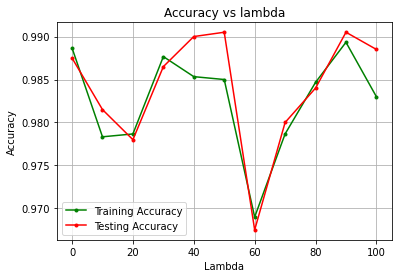

In [47]:
c = range(0, 101, 10)
plt.plot(c,train,'.-',color='green')
plt.plot(c,test,'.-',color='red')
plt.title("Accuracy vs lambda")
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.grid()

In [49]:
test[5]
train[5]

0.985